Tutorial on YouTube Chanel:
Text Visualization | Lecture 2 | CPE 393 Text Analytics
https://www.youtube.com/watch?v=rAQCQKnkNh0&t=774s

##### <b>Load Dataset</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
df = pd.read_csv('un-general-debates.csv')
df.sample(5)

,session,year,country,text
6504,45,1990,NER,﻿For my delegation and for myself it is a plea...
291,68,2013,LUX,The President of the General Assembly has chos...
2680,50,1995,BRB,"It is my pleasure to\ncongratulate you, Sir, o..."
3362,34,1979,MEX,"﻿Mr. President, it is significant and encourag..."
3464,54,1999,USA,"Today, we look ahead to the\nnew millennium. A..."


In [3]:
df.count()

session    7507
year       7507
country    7507
text       7507
dtype: int64

In [4]:
# Primary key

df[['session', 'country']].drop_duplicates().count()

session    7507
country    7507
dtype: int64

##### <b>DataFrame Summary Statistics</b>

In [5]:
df['length'] = df['text'].str.len()

In [6]:
df.columns

Index(['session', 'year', 'country', 'text', 'length'], dtype='object')

In [7]:
df.dtypes

session     int64
year        int64
country    object
text       object
length      int64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   session  7507 non-null   int64 
 1   year     7507 non-null   int64 
 2   country  7507 non-null   object
 3   text     7507 non-null   object
 4   length   7507 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 293.4+ KB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


In [10]:
df[['country']].describe(include='O').T

,count,unique,top,freq
country,7507,199,IRN,46


##### <b>Check Missing Data</b>

In [11]:
df.isna().sum()

session    0
year       0
country    0
text       0
length     0
dtype: int64

##### <b>Plotting distribution</b>

<AxesSubplot:>

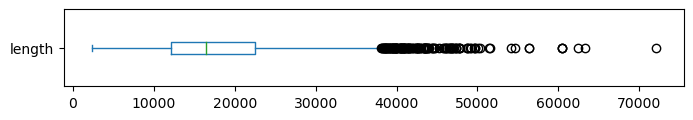

In [12]:
df['length'].plot(kind='box', vert=False, figsize=(8,1))

<AxesSubplot:ylabel='Frequency'>

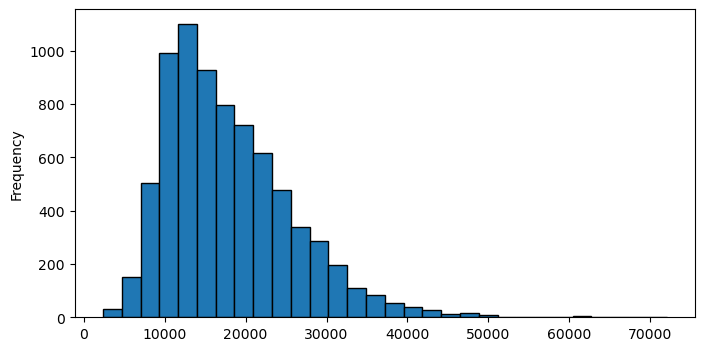

In [13]:
df['length'].plot(kind='hist', bins=30, figsize=(8,4), edgecolor='k')

##### <b>Distribution across categories</b>

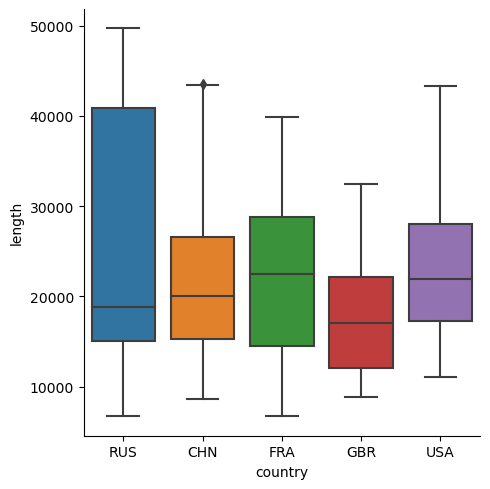

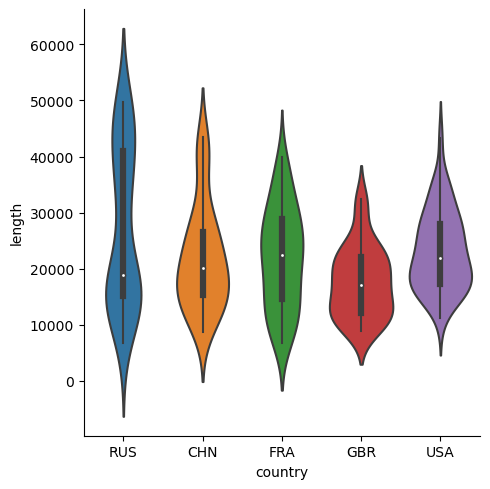

In [14]:
import seaborn as sns

where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
sns.catplot(data=df[where], x='country', y='length', kind='box')
sns.catplot(data=df[where], x='country', y='length', kind='violin')

##### <b>Developement over time Number of countries</b>

<AxesSubplot:title={'center':'Number of Countries'}, xlabel='year'>

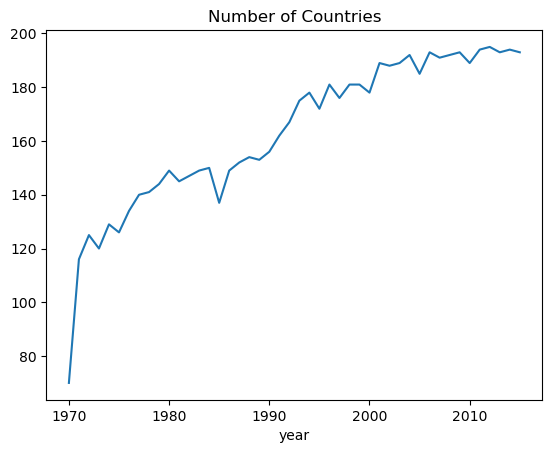

In [15]:
df.groupby('year').size().plot(title='Number of Countries')

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

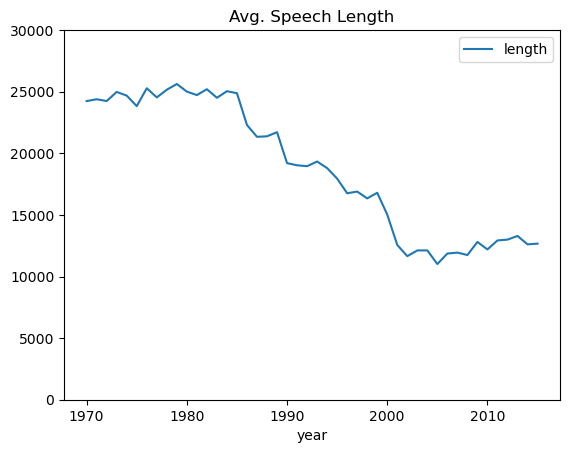

In [16]:
df.groupby('year').agg({'length':'mean'}).plot(title='Avg. Speech Length', ylim=(0,30000))

##### <b>Simple Text Processing</b>

In [17]:
# Case Folding
str.lower('Hello World')

'hello world'

In [18]:
# Tokenization

import regex as re
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [19]:
text = "Let's defeat SARS-Coc-2 together in 2021!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-Coc-2|together|in


In [20]:
# Stop word removal
import nltk
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samapant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [21]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [22]:
remove_stop(tokens)

['Let', 'defeat', 'SARS-Coc-2', 'together']

In [23]:
# Processing a pipeline

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [24]:
prepare(text, pipeline)

['let', 'defeat', 'sars-coc-2', 'together']

In [25]:
# Apply pipeline

# Series: map
# Series: map
# DaraFrame: applymap
# DataFrame: applymap

df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)
df.sample(10)

,session,year,country,text,length,tokens
5849,32,1977,CSK,"﻿161.\tComrade President, I have already taken...",25545,"[comrade, president, already, taken, opportuni..."
7441,56,2001,JPN,﻿I would like to\ncongratulate Mr. Han Seung-s...,6712,"[would, like, congratulate, mr, han, seung-soo..."
148,44,1989,CPV,"﻿I am very pleased to greet you, Sir, and offe...",23283,"[pleased, greet, sir, offer, warm, congratulat..."
7251,62,2007,LIE,"Climate \nchange, at the centre of the high-le...",6976,"[climate, change, centre, high-level, event, w..."
7401,56,2001,PSE,﻿I would\nlike to begin by extending my congra...,15907,"[would, like, begin, extending, congratulation..."
3018,26,1971,POL,"107.\t Mr. President, on behalf of the delega...",34455,"[mr, president, behalf, delegation, polish, pe..."
767,46,1991,FRA,"﻿\nI should like to congratulate you, Sir, on ...",20571,"[like, congratulate, sir, election, president,..."
4188,53,1998,NLD,I speak to this Assembly with a sense of defer...,12514,"[speak, assembly, sense, deference, humility, ..."
3457,34,1979,SLV,﻿The just recognition by all delegations of yo...,23265,"[recognition, delegations, high, qualities, si..."
119,44,1989,HND,﻿I feel very honoured to be here once again to...,23735,"[feel, honoured, speak, general, assembly, beh..."


In [26]:
# Counting number of tokens (words)
df['num_tokens'] = df['tokens'].map(len)
df.sample(10)

,session,year,country,text,length,tokens,num_tokens
1295,30,1975,LSO,129.\t On behalf of the Government of the King...,25204,"[behalf, government, kingdom, lesotho, wish, e...",2089
5010,69,2014,RWA,"I want to start by congratulating \nyou, Sir, ...",3377,"[want, start, congratulating, sir, election, p...",282
380,68,2013,DOM,"At the outset, I wish to express my \ncongratu...",12757,"[outset, wish, express, congratulations, presi...",1021
1803,52,1997,TUN,﻿Allow me to begin by expressing my warmest\nc...,20126,"[allow, begin, expressing, warmest, congratula...",1646
5014,69,2014,BGD,I warmly \ncongratulate Mr. Sam Kutesa on his ...,16201,"[warmly, congratulate, mr, sam, kutesa, electi...",1380
516,40,1985,DDR,Permit me first of all to assure the people an...,18814,"[permit, first, assure, people, government, me...",1594
6760,49,1994,COG,At this forty-ninth session of the General\nAs...,18539,"[forty-ninth, session, general, assembly, unit...",1570
5178,66,2011,LIE,It is a great honour to \nagain address this A...,9543,"[great, honour, address, assembly, especially,...",805
924,41,1986,IND,"\nAt the outset. Sir, I extend to you once aga...",22629,"[outset, sir, extend, felicitations, delegatio...",1896
6951,61,2006,JOR,May I extend \nthe warmest congratulations to ...,3638,"[may, extend, warmest, congratulations, sheikh...",309


##### <b>Word Frequency Analysis</b>

In [27]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa")
counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [28]:
more_tokens = tokenize("She likes dogs and cats")
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


In [29]:
%%time
import numpy as np
tokens = df['tokens'].explode().values
counter = Counter(tokens)
# print(counter)
print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]
Wall time: 2.88 s


In [30]:
%%time
counter = Counter()
df['tokens'].map(counter.update)

print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]
Wall time: 1.93 s


In [31]:
# Word Counting, DataFrame Version

def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # tranform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq > @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [32]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


In [33]:
# Counting words with preprocessing

# Count words with 10 or more characters
count_words(df, column='text',
            preprocess=lambda text: re.findall(r"\w{10,}", text))

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177
...,...
Documentation,3
instrumentation,3
Reorganization,3


##### <b>Frequency Plot</b>

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

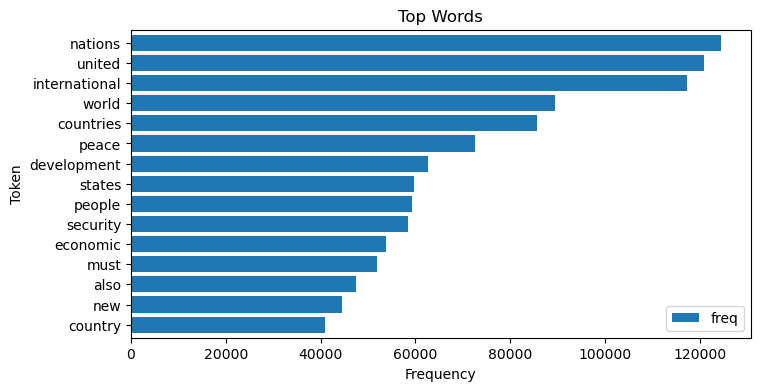

In [34]:
ax = freq_df.head(15).plot(kind='barh', width=0.8, figsize=(8,4))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

##### <b>Word Cloud</b>

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = df.query("year==2015 and country=='USA'")['text'].values[0]
text

'Seventy years after the founding of the United Nations it is worth reflecting on what the members of this body, working together, have helped to achieve. Out of the ashes of the Second World War, having witnessed the unthinkable power of the atomic age, the United States has worked with many nations in the Assembly to prevent a third world war — by forging alliances with old adversaries; by supporting the steady emergence of strong democracies accountable to their people and not to any foreign Power; and by building an international system that imposes a cost on those who choose conflict over cooperation, an order that recognizes the dignity and equal worth of all people.\nThat has been the work of seven decades. That is the ideal that this body has, at its best, pursued. Of course, there have been too many times when, collectively, we have fallen short of those ideals. Over the seven decades, terrible conflicts have claimed untold victims. But we have pressed forward, slowly, steadil

(-0.5, 399.5, 199.5, -0.5)

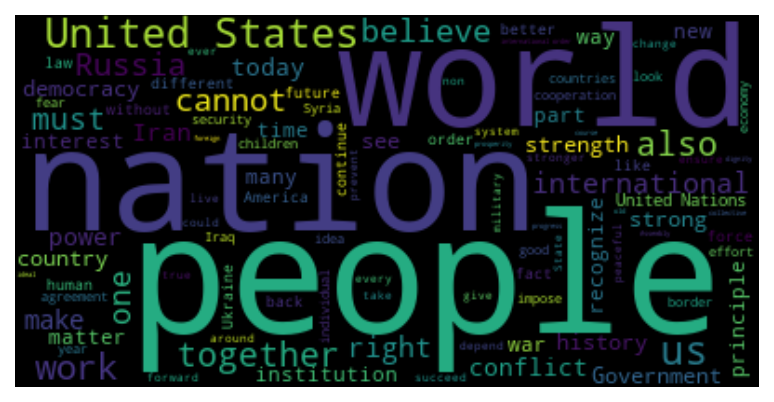

In [37]:
wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)
plt.figure(dpi=150)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

##### <b>Keyword-in-Context Function</b>

In [38]:
from textacy.extract.kwic import keyword_in_context
import random

def kwic(doc_series, keyword, window=35, print_samples=5):
    
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' + \
                  sample[1] + ' ' + re.sub(r'[\n\t]', ' '. sample[2]))

In [39]:
kwic(df[df['year']==2005]['text'], 'sdgs', print_samples=5)

0 random samples out of 0 contexts for 'sdgs':


##### <b>N-Gram</b>

In [40]:
def ngram(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

text = 'the visible manifestation of the global climate change'
tokens = tokenize(text)
print(tokens)

print("|".join(ngram(tokens,2)))

['the', 'visible', 'manifestation', 'of', 'the', 'global', 'climate', 'change']
the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


In [41]:
# N-Gram with stopwords removal

def ngram(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

text = 'the visible manifestation of the global climate change'
tokens = tokenize(text)
print(tokens)

print("|".join(ngram(tokens,2,stopwords=stopwords)))

['the', 'visible', 'manifestation', 'of', 'the', 'global', 'climate', 'change']
visible manifestation|global climate|climate change


##### <b>Creating frequency timelines</b>

In [42]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0 ) for k in keywords]

In [43]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'terrorism', 'climate', 'freedom', 'climate', 'freedom']

In [44]:
print(count_keywords(tokens=tokens, keywords=keywords))

[1, 1, 2, 2]


In [45]:
def count_keywords_by(df, by, keywords, column='tokens'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]

    return freq_df.groupby(by).sum().sort_values(by)

In [46]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df.head(10)

,nuclear,terrorism,climate,freedom
year,,,,
1970,192,7,18,128
1971,275,9,35,205
1972,393,379,74,280
1973,347,124,79,266
1974,478,24,71,316
1975,578,20,53,232
1976,451,146,57,347
1977,675,75,58,321
1978,550,82,52,309


<AxesSubplot:xlabel='year'>

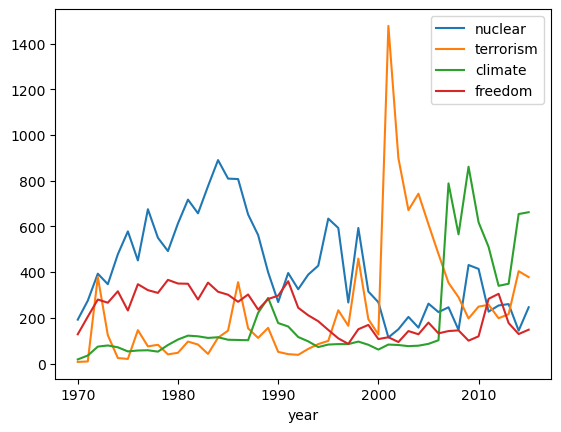

In [47]:
freq_df.plot(kind='line')

##### <b>Homework</b>

In [ ]:
# Find the top 10 word bigram from US General Debates of year 1970-1990 and compare with those of years 1990-the lastest (remove stopwords first)



In [ ]:
# Create a bigram word cloud of the US General Debates datasetof years 1970 and 1990 to the lastest (remove stopwords first)



In [ ]:
# Create a trend graph showing the bigram and word trend of "climate change", "global warming", "wars", and 3 others of your choices

